In [1]:
import numpy as np 
import pandas as pd 
import FinanceDataReader as fdr
import matplotlib.pyplot as plt 

import datetime 

import torch 
import torch.nn as nn 
from torch.autograd import Variable 

import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader

In [2]:
df = fdr.DataReader('KS11')
df['Close'].plot()

<AxesSubplot:xlabel='Date'>

In [3]:
X = df.drop(columns=['Volume','Change'])
y = df.iloc[:, 5:6]

print(X)
print(y)

              Close     Open     High      Low
Date                                          
1981-05-01   123.60   123.60   123.60   123.60
1981-05-02   123.50   123.50   123.50   123.50
1981-05-04   120.60   120.60   120.60   120.60
1981-05-06   120.70   120.70   120.70   120.70
1981-05-07   119.30   119.30   119.30   119.30
...             ...      ...      ...      ...
2021-09-17  3140.51  3127.75  3142.13  3112.51
2021-09-23  3127.58  3123.64  3131.63  3107.98
2021-09-24  3125.24  3140.73  3146.86  3119.40
2021-09-27  3133.64  3121.70  3146.35  3119.26
2021-09-28  3097.92  3133.40  3134.46  3095.72

[10795 rows x 4 columns]
            Change
Date              
1981-05-01  0.0098
1981-05-02 -0.0008
1981-05-04 -0.0235
1981-05-06  0.0008
1981-05-07 -0.0116
...            ...
2021-09-17  0.0033
2021-09-23 -0.0041
2021-09-24 -0.0007
2021-09-27  0.0027
2021-09-28 -0.0114

[10795 rows x 1 columns]


In [4]:
data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.70): int(len(df))])

print(data_training.shape)
print(data_testing.shape)

(7556, 1)
(3239, 1)


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [6]:
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.00898992],
       [0.00893887],
       [0.00745842],
       ...,
       [0.71807071],
       [0.71006606],
       [0.71272066]])

In [7]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)  

In [8]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [9]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
              input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))


model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))


model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 60)           26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 60)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 80)           45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 80)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

In [15]:
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics ='mae')
history = model.fit(x_train, y_train,
                    epochs = 50)

Epoch 1/50
233/233 [==============================] - 22s 87ms/step - loss: 0.0013 - mae: 0.0254
Epoch 2/50
233/233 [==============================] - 20s 87ms/step - loss: 0.0013 - mae: 0.0250
Epoch 3/50
233/233 [==============================] - 20s 87ms/step - loss: 0.0013 - mae: 0.0251
Epoch 4/50
233/233 [==============================] - 20s 87ms/step - loss: 0.0013 - mae: 0.0253
Epoch 5/50
233/233 [==============================] - 20s 87ms/step - loss: 0.0013 - mae: 0.0251
Epoch 6/50
233/233 [==============================] - 20s 87ms/step - loss: 0.0012 - mae: 0.0240
Epoch 7/50
233/233 [==============================] - 20s 87ms/step - loss: 0.0013 - mae: 0.0249
Epoch 8/50
233/233 [==============================] - 20s 86ms/step - loss: 0.0013 - mae: 0.0251
Epoch 9/50
233/233 [==============================] - 20s 87ms/step - loss: 0.0013 - mae: 0.0249
Epoch 10/50
233/233 [==============================] - 20s 87ms/step - loss: 0.0013 - mae: 0.0247
Epoch 11/50
233/233 [========

In [18]:
model.save('LSTM_model.h5')

In [26]:
past_100_days = data_training.tail(100)

In [27]:
final_df = past_100_days.append(data_testing, ignore_index=True)

In [28]:
input_data = scaler.fit_transform(final_df)

In [29]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])
    y_test.append(input_data[i, 0])

In [30]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(3239, 100, 1)
(3239,)


In [31]:
y_predicted = model.predict(x_test)

In [32]:
scaler.scale_

array([0.00042257])

In [33]:
scale_factor = 1/0.00042257
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

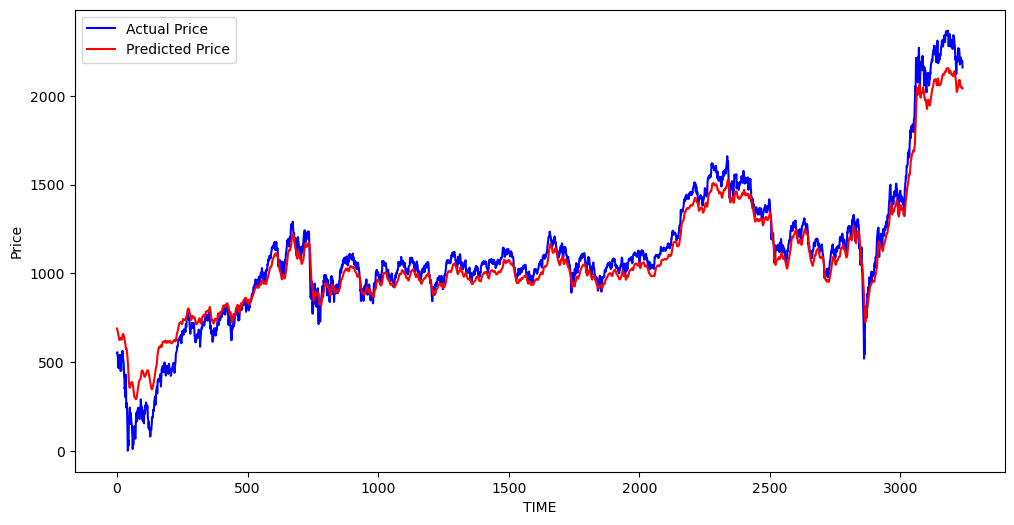

In [34]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b', label = 'Actual Price')
plt.plot(y_predicted, 'r', label = 'Predicted Price')
plt.xlabel('TIME')
plt.ylabel('Price')
plt.legend()
plt.show()

In [24]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price KRW (\)', fontsize=18)
plt.legend()
plt.show()

NameError: name 'test_label' is not defined